In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/Users/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
import os

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

from wavenet import model, train, sample, audio, datasets, utils, viz

# Train on 440 hz Sines random phases

A very simple dataset, should be able to crush this. Sines all at 440 hz, unit amplitude, random phases. Some ways of reducing the size of the problems:

- 4 cycles of sin should do, no need for a full second of audio. 160 samples
- Mu compress to 7 bits
- Fast generate only 160 samples
- Mono

We will try to train in around 10 minutes. 

In [3]:
dry = True 
if dry: os.environ['WANDB_MODE'] = 'disabled'

In [4]:
p = model.HParams(
    mixed_precision=True,
    n_audio_chans=1, 
    n_classes=2**7, 
    compress=False, 
    sample_length=160, 
    dilation_stacks=1,
    n_layers=8,
    sample_from_gpu=True,
    seed=32455
    
).with_all_chans(32)

utils.seed(p)
ds = datasets.Sines(
    640, p, 
    hz=440, 
    amp=1.0
)

ds_test = datasets.Sines(
    640, p, 
    hz=440, 
    amp=1.0
)

m = model.Wavenet(p)
tp = train.HParams(
    max_epochs=10, 
    batch_size=16, 
    num_workers=1, 
    learning_rate=0.015, 
    onecycle=True
)

t = train.Trainer(m, ds, ds_test, tp, None)
p.receptive_field_size()

/Users/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/cuda/amp/grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


256

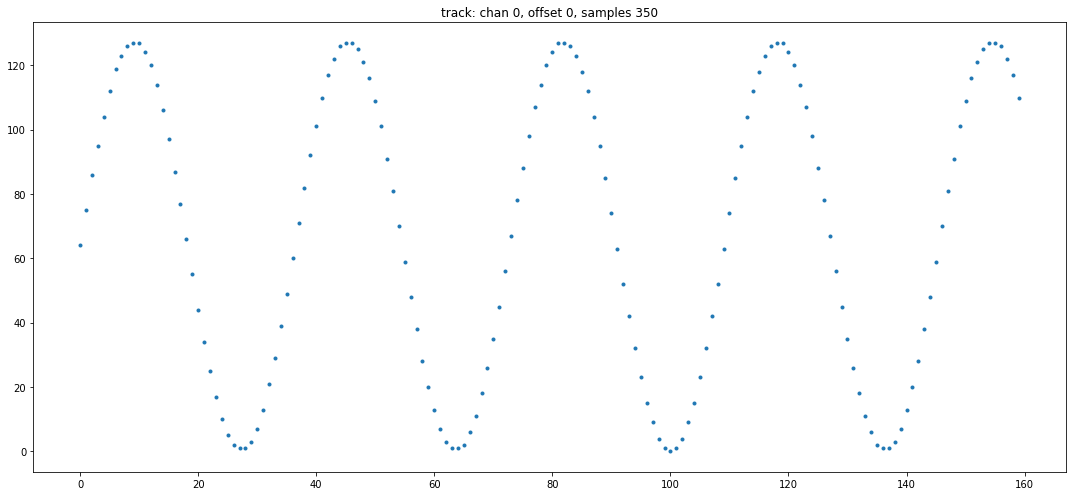

In [5]:
track_i = viz.plot_random_track(ds, style='.')
*_, track = ds[track_i]
ipd.Audio(track, rate=p.sampling_rate)

In [6]:
utils.seed(p)
t.train()

  0%|          | 0/40 [00:00<?, ?it/s]/Users/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
10:39 loss 0.00002 lr 5.320725e-07: 100%|██████████| 40/40 [00:05<00:00,  7.43it/s]


# Results

Let's inspect what the model has learned by generating samples and laying them over each other.

In [7]:
def generate(m, ds, decoder, n_samples=256, batch_size = 10):
    track, *_ = sample.fast(m, ds.transforms, decoder, n_samples=n_samples, batch_size=batch_size)
    plt.figure(figsize=(15, 8))
    for i in range(batch_size):
        plt.plot(track.cpu()[i, 0, :])

## Argmax

The model has learned that sin is the most likely mode of the data. This is with starting values of 0. I'm not sure why this should be the case exactly, since I would expect starting values to be uniformly distributed between 0 and 120.

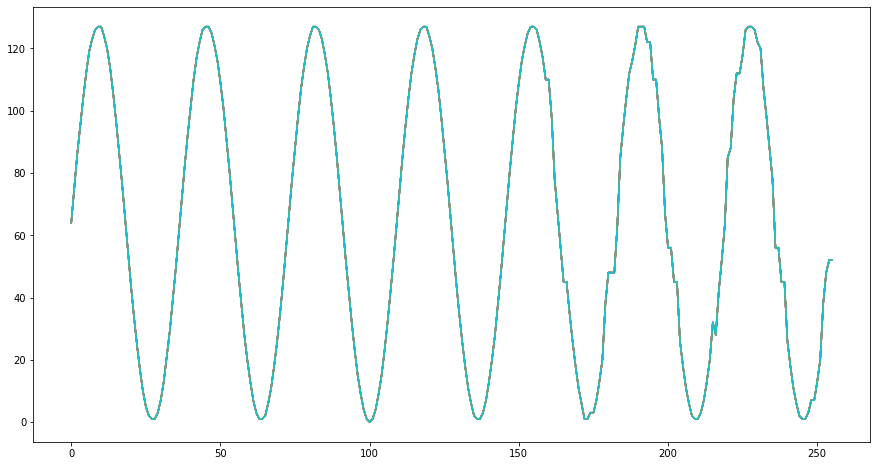

In [8]:
utils.seed(p)
generate(m, ds, utils.decode_argmax)

## Nucleus sampling with very likely values

Using nucleus sampling, we can relax the argmax a bit. Here we retain the top propbability mass. Now we've captured both `sin` and `cos`, respectively starting at the minimum and maximum values.

/Users/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


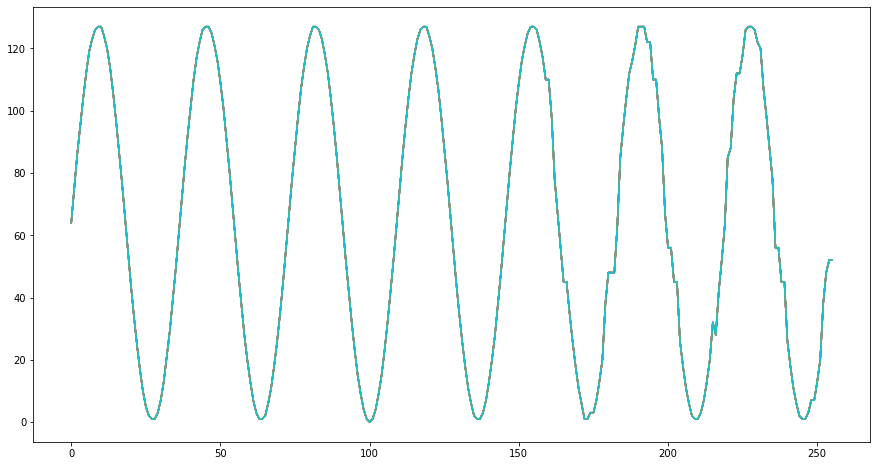

In [9]:
utils.seed(p)
generate(m, ds, utils.decode_nucleus(core_mass=0.14))

## Nucleus sampling, relaxed a bit more

Now we've grabbed a further mode, which sometimes starts in the middle at 60 – the mean of `sin` and `cos`. There's more jitter overall.

/Users/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


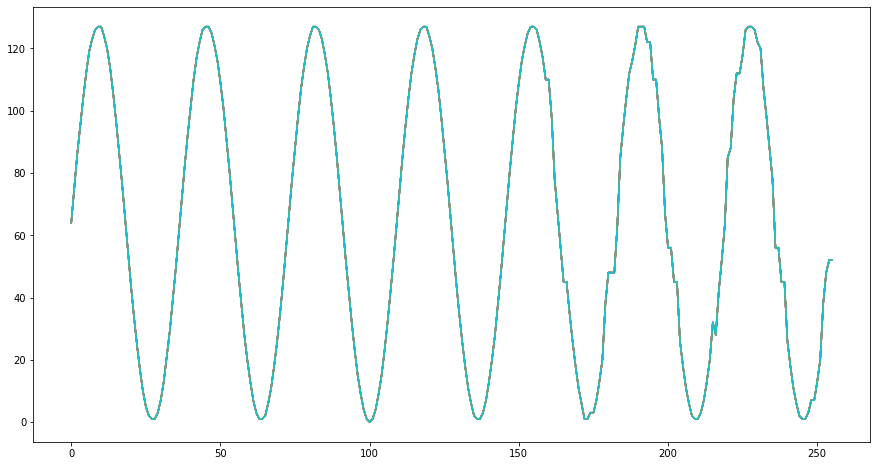

In [10]:
utils.seed(p)
generate(m, ds, utils.decode_nucleus(core_mass=0.4))

## Random

Now we're trying to reproduce the original distribution. Note that we still haven't got a very uniform reproduction.

/Users/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


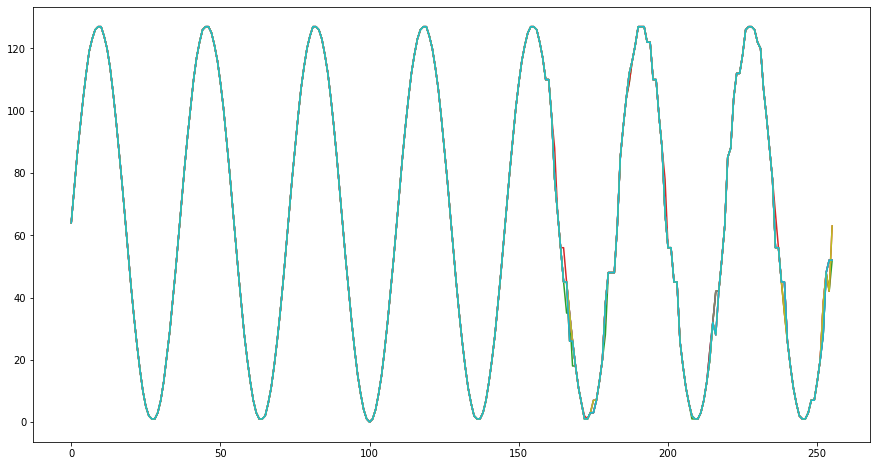

In [11]:
utils.seed(p)
generate(m, ds, utils.decode_random)

# Train on random Sinusoids

Harder.

In [12]:
utils.seed(p)
ds = datasets.Sines(6400, p, amp=1.0, minhz=20, maxhz=400)
ds_test =datasets.Sines(640, p, amp=1.0, minhz=20, maxhz=400)

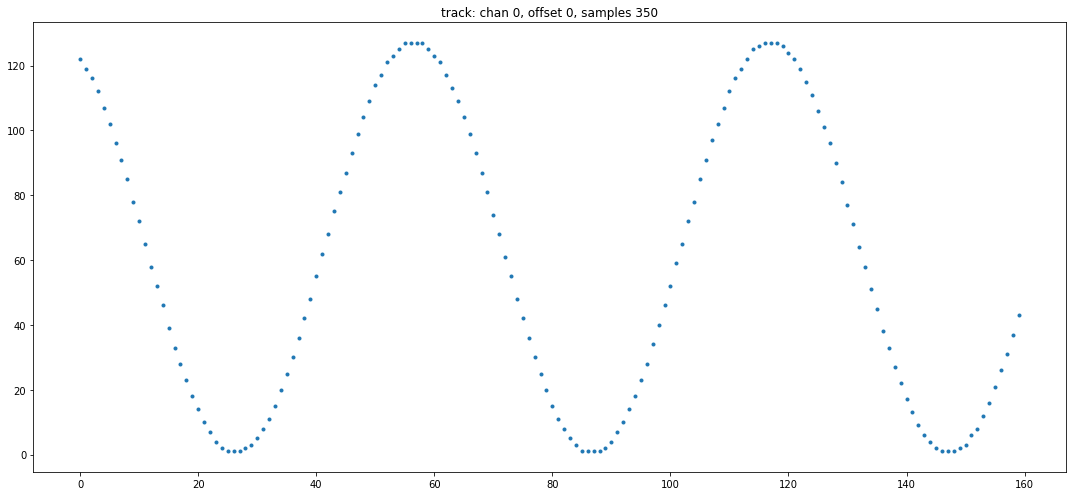

In [13]:
track_i = viz.plot_random_track(ds, style='.')
*_, track = ds[track_i]
ipd.Audio(track, rate=p.sampling_rate)

In [14]:
m = model.Wavenet(p.with_all_chans(64))
tp = train.HParams(
    max_epochs=20, 
    batch_size=16, 
    num_workers=1, 
    learning_rate=0.015, 
    onecycle=True
)

t = train.Trainer(m, ds, ds_test, tp, None)
p.receptive_field_size()

/Users/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/cuda/amp/grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


256

In [15]:
utils.seed(p)
t.train()

  0%|          | 0/400 [00:00<?, ?it/s]/Users/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
17:166 loss 4.63104 lr 2.292804e-03:  42%|████▏     | 167/400 [00:20<00:28,  8.10it/s]


KeyboardInterrupt: 

## Argmax

In [ ]:
utils.seed(p)
generate(m, ds, utils.decode_argmax)

## Nucleus sampling with very likely values


In [ ]:
utils.seed(p)
generate(m, ds, utils.decode_nucleus(core_mass=0.14))

## Nucleus sampling, relaxed a bit more


In [ ]:
utils.seed(p)
generate(m, ds, utils.decode_nucleus(core_mass=0.4))

## Random

In [ ]:
utils.seed(p)
generate(m, ds, utils.decode_random)

# Train on 20 hz Sines

This is a bit of a puzzle. Given the same resources as training on 440 hz sines with random phases, this performs much worse:

In [ ]:
p = model.HParams(
    mixed_precision=True,
    n_audio_chans=1, 
    n_classes=2**7, 
    compress=False, 
    sample_length=160, 
    dilation_stacks=1,
    n_layers=8,
    sample_from_gpu=True,
    seed=32455
    
).with_all_chans(32)

utils.seed(p)
ds = datasets.Sines(
    640, p, 
    hz=440, 
    amp=1.0, 
    phase=0
)

ds_test = datasets.Sines(
    640, p, 
    hz=440, 
    amp=1.0, 
    phase=0
)

m = model.Wavenet(p)
tp = train.HParams(
    max_epochs=10, 
    batch_size=16, 
    num_workers=1, 
    learning_rate=0.015, 
    onecycle=True
)

t = train.Trainer(m, ds, ds_test, tp, None)
p.receptive_field_size()

In [ ]:
utils.seed(p)
t.train()

In [ ]:
utils.seed(p)
generate(m, ds, utils.decode_argmax)
generate(m, ds, utils.decode_nucleus(core_mass=0.14))
generate(m, ds, utils.decode_nucleus(core_mass=0.4))
generate(m, ds, utils.decode_random)